# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

In [6]:

def f_write_config(input_dict,fname):
    
    with open(fname,'w') as f:
        yaml.dump(input_dict,f,sort_keys=False)
    
def f_read_config(fname):
    
    with open(fname,'r') as f:
        config_dict=yaml.load(f, Loader=yaml.SafeLoader)
        
    return config_dict

### Gather observables

In [7]:
def f_get_plaquette(fname,dict1):
    
    try: 
        cmd="grep 'Plaquette' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string        

        arr=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), np.float64(i.split(' ')[-1])] 
                         for i in op])
        
        ## Hack for when Plaquette is printed twice : smeard and unsmeared
        arr=arr[0::2]
        
        dict1['Plaquette']=arr[:,1]
        dict1['iter'] = arr[:,0]
        
    except Exception as e: 
        print("Couldn't extract Plaquette values")
        print(e)
    
    return dict1

def f_get_polyakov(fname,dict1):
    
    try: 
        cmd="grep 'Polyakov' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        arr=[]
        for i in op: 
            strg=i.split(' ')[-1][1:-1]
            arr.append(complex(np.float64(strg.split(',')[0]),np.float64(strg.split(',')[1])))
    
        dict1['Polyakov']=arr

    except Exception as e: 
        print("Couldn't extract Polyakov values")
        print(e)
    
    return dict1


def f_get_traj_time(fname,dict1):
    
    try: 
        cmd="grep 'Total time for trajectory' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string
        
        arr=[np.float32(i.split(': ')[-1]) for i in op]
        dict1['Traj_time']=arr

    except Exception as e: 
        print("Couldn't extract total Traj times")
        print(e)
        
    return dict1



def f_get_metropolis(fname,dict1,lgth):
    
    try: 
        cmd="grep 'Metropolis_test' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        ## Other arrays have equilibriation data, metropolis doesn't. So we need to add nans to make them the same size
        arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
        skip=lgth-len(arr_temp)
        arr_skip=[np.nan for i in range(skip)]
        arr=np.array(arr_skip+arr_temp)
        dict1['Accept']=arr

    except Exception as e: 
        print("Couldn't extract total Metropolis info")
        print(e)
    
    return dict1

def f_parse_grid_data(fname):
    
    dict1={}
    
    f_get_plaquette(fname,dict1)
    
    f_get_polyakov(fname,dict1)
    
    f_get_traj_time(fname,dict1)    
    
    ## Check if list sizes are unequal
    size_lst=[len(val) for val in dict1.values()]
    lg=size_lst[0]
    for i in size_lst:
        if i!=lg: 
            print("Unequal sizes of dict elements")
            print([(key,len(val)) for key,val in dict1.items()])
    
    lgth = min([len(i) for i in dict1.values()])
    f_get_metropolis(fname,dict1,lgth)

    ## Store in DataFrame
    df=pd.DataFrame([])
    for key in dict1.keys():
        df[key]=pd.Series(dict1[key])
        
    return df

# df=f_parse_grid_data(fname)

In [8]:
def f_jackknife(arr):
    # Jackknife an input array to get sdev 
    
    N=arr.shape[0]
    arr_samples=np.zeros(N) # Array to store samples
    
    for i in range(N):
        arr2=np.delete(arr,i)
        arr_samples[i]=np.mean(arr2)
    
    # Compute mean and std. deviation
    mean=np.mean(arr_samples)
    err=np.sqrt( np.sum((arr_samples-mean)**2) * ((N-1)/N) ) # sqrt( (N-1) * variance ) for jackknife
#     err2=np.std(arr_samples)
#     print(err,err2)

    return gv.gvar(mean,err)
    
# arr=np.random.normal(5,1,10)
# f_jackknife(arr)

In [9]:
def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
#     m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         m[i]=gv.dataset.avg_data(y**i)
        
    ## Check moments obtained by gvar, with direct calculation
#     n=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     n[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         arr=y**i
#         n[i]=gv.gvar(np.mean(arr),np.std(arr)/np.sqrt(arr.shape[0]))
    
#     sus=(L**3)*(m[2]-(m[1]**2))
#     kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)

    
    ## Propagating errors for high correlated variables doesn't work, so we use jackknife
    ### Compute arrays of moments
    m=[y**i for i in range(0,5)] # List to store powers of input
    
    ## Compute sus and kurt by jackknifing elements of this list
    arr=(y-np.mean(y))**2
    sus=(L**3) * f_jackknife(arr)
#     print(sus)
    
    if sus>1e-7:
#         arr=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
        arr=((y-np.mean(y))**4)
        kurt= f_jackknife(arr) / (gv.mean(sus)**2)
    else: kurt=gv.gvar(np.nan,np.nan)
    return sus,kurt

    
    
    
def f_get_summary_data(df,L,dict1,equil=30):
    drop_idx=equil
    print("Using equilibriation ", equil)
    

    ## Plaquette 
    y=df.Plaquette.values[drop_idx:]
    dict1['plaq'] = gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_plaq'],dict1['kurt_plaq']=f_moments(y,L)
    
    ## Polyakov Loop
    y=np.abs(df.Polyakov.values[drop_idx:])
    dict1['polyakov']=gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_poly'],dict1['kurt_poly']=f_moments(y,L)

    
    ## Trajectory time
    y=df.Traj_time.values[drop_idx:]
    dict1['traj_time']=gv.dataset.avg_data(y)
    
    
    ## Acceptance info
    y=df['Accept'].dropna().values
    Act=y[y==1].shape[0]
    Rjt=y[y==0].shape[0]
    accpt=Act* 100 /(Act+Rjt)

    dict1['accept']=accpt

    ## num of configs
    y=df.Plaquette.values[drop_idx:]
    dict1['num_conf']=y.shape[0]
    
    return dict1



$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] = L^3 \langle (\mathcal{O} - \bar{\mathcal{O}})^2\rangle $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2} = \frac{ \langle \left( \mathcal{O-\bar{\mathcal{O}}} \right) ^4 \rangle }{\chi_\mathcal{O}^2}$$ 

In [22]:
input_dict

{'Lx': 16,
 'Lt': 8,
 'F_action': 'Mobius_dwf',
 'traj_l': 2,
 'md_steps': 15,
 'dwf_Ls': 16,
 'mpi': '2.2.2.1',
 'nprocs': 8,
 'N': 1,
 'start_type': 'HotStart',
 'beta': 10.0,
 'mf': 0.1}

In [23]:

Lx='*'
Lt='*'
data_dict={}
df_summary=pd.DataFrame([])

# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/'
# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram/'
# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/'
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/'


flist=glob.glob(top_dir+'run_Lx-%s_Lt-%s*'%(Lx,Lt))
# print(flist)

for run_fldr in flist: 
    fname=run_fldr+'/HSDM.out'
#     print(fname)
    
    if not os.path.isfile(fname): 
        print("File %s doesn't exist"%(fname))
        continue
        
    # Read config file from folder
    input_dict=f_read_config(run_fldr+'/config.yaml')
    
    df=f_parse_grid_data(fname)
#     display(df)
        
    key='beta-%s_mf-%s_Lx-%s_Lt-%s'%(input_dict['beta'],input_dict['mf'],input_dict['Lx'],input_dict['Lt'])
    
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        key+='_Ls-%s'%(input_dict['dwf_Ls'])
    
    count=1
    while(key in data_dict.keys()): # If duplicate key, add suffix
        print("Key exists",key,fname)
        count+=1
        key=key+'_%s'%(count)
        if count>10: break
        
    data_dict[key]=df
    
    # Get summary data
    dict2={}
    for key in ['beta','mf','Lx','Lt']:   dict2[key]=input_dict[key]
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        dict2['Ls']=input_dict['dwf_Ls']
    dict2=f_get_summary_data(df,input_dict['Lx'],dict2,50)
        
    df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)
display(df_summary)


Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50
Using equilibriation  50


,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept,num_conf
0,10.0,0.1,16,8,16,0.413527(62),0.00189(31),2.5(1.0)e-07,0.00354(16),0.0129(22),2.7(1.4)e-07,141.403(22),78.125000,120
1,10.0,0.1,24,8,16,0.413160(57),0.00260(44),1.34(41)e-08,0.00144(12),0.0113(42),4.5(4.1)e-08,336.33(10),71.134021,57
2,10.2,0.1,16,8,16,0.442378(89),0.00384(45),1.55(31)e-07,0.00337(15),0.0108(12),1.44(29)e-07,142.857(26),88.607595,118
3,10.2,0.1,24,8,16,0.441694(80),0.00498(66),1.04(25)e-08,0.00213(14),0.0165(51),3.4(2.0)e-08,337.769(74),75.257732,57
4,10.4,0.1,16,8,16,0.51334(24),0.0303(20),9.3(1.3)e-08,0.00340(15),0.0118(17),2.16(91)e-07,134.351(93),92.215569,127
5,10.4,0.1,24,8,16,0.51231(27),0.0625(92),1.20(36)e-08,0.00194(13),0.0134(23),1.42(51)e-08,321.20(23),95.000000,60
6,10.6,0.1,16,8,16,0.547152(63),0.00250(25),1.50(30)e-07,0.00442(17),0.0191(22),1.79(46)e-07,114.31(24),96.391753,154
7,10.6,0.1,24,8,16,0.547001(55),0.00302(46),1.40(36)e-08,0.00277(17),0.0292(30),9.3(1.6)e-09,281.25(70),87.610619,73
8,10.8,0.1,16,8,16,0.564422(44),0.00130(14),1.69(32)e-07,0.00598(26),0.0458(66),2.53(89)e-07,99.51(10),94.500000,160
9,10.8,0.1,24,8,16,0.564332(34),0.00140(20),1.42(45)e-08,0.00533(20),0.0492(69),1.43(37)e-08,243.84(54),91.472868,89


In [17]:
# df_summary[df_summary.beta==10.8]
# display(df_summary)

array(['8_16', '8_24'], dtype='<U4')

In [11]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.2_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.4_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.6_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.8_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-11.0_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-11.2_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-11.4_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-11.8_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-12.0_mf-0.1_Lx-24_Lt-8_Ls-16'])

In [12]:
# data_dict['beta-10.8_mf-0.02_Lx-16_Lt-32_Ls-32']

## Summary plots

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [24]:
mf_list   = np.sort(np.unique(df_summary.mf.values))
beta_list = np.sort(np.unique(df_summary.beta.values))
Lt_list = np.sort(np.unique(df_summary.Lt.values))

# L_list=np.unique([str(i)+'_'+str(j) for i,j in zip(df_summary.Lt.values, df_summary.Lx.values)])

<IPython.core.display.Javascript object>


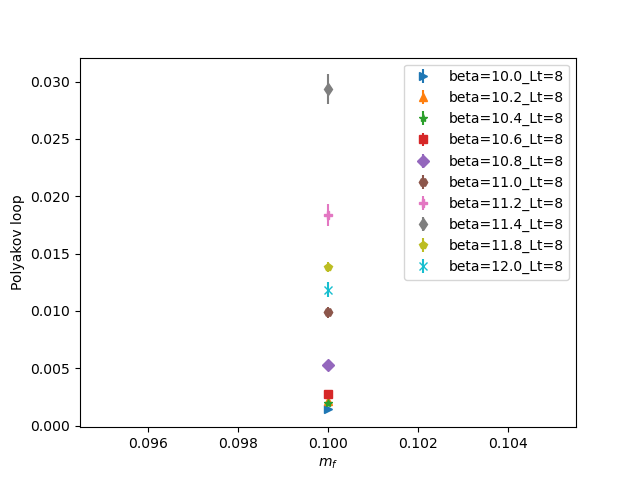

Text(0, 0.5, 'Polyakov loop')

In [14]:
plt.figure()

for Lt in Lt_list:
    df=df_summary[df_summary.Lt==Lt]
    for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):
        label='beta=%s_Lt=%s'%(beta,Lt)
        df1=df[df.beta==beta].sort_values(by=['mf'])
    #     display(df1)

    #     if df1.shape[0]>1:
        x=df1.mf.values
        y=df1.polyakov.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.savefig('Ploop_vs_mf.pdf')

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


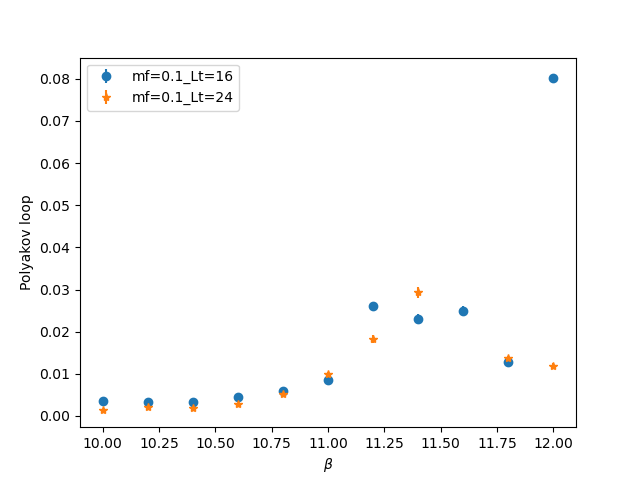

Text(0, 0.5, 'Polyakov loop')

In [44]:
plt.figure()

for (Lt,marker) in zip(Lt_list,itertools.cycle('o*d>^sDHPdpx_')):
    df=df_summary[df_summary.Lt==Lt]
#     for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    for mf in mf_list:
        label='mf=%s_Lt=%s'%(mf,Lt)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.polyakov.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        
plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('Ploop_vs_beta.pdf')

### Plaquette vs beta

<IPython.core.display.Javascript object>


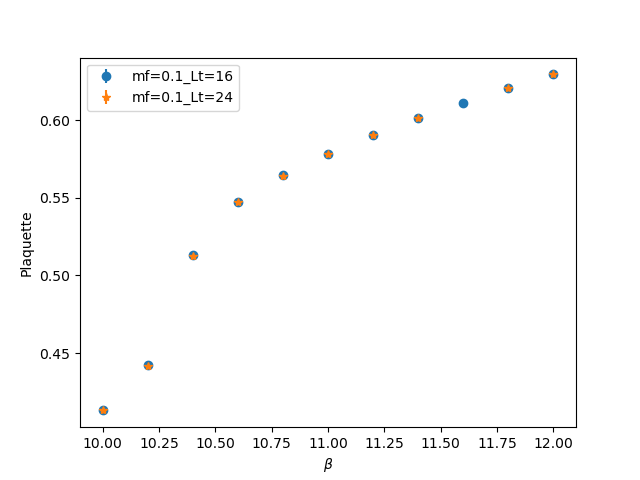

Text(0, 0.5, 'Plaquette')

In [43]:
plt.figure()

for (Lt,marker) in zip(Lt_list,itertools.cycle('o*d>^sDHPdpx_')):
    df=df_summary[df_summary.Lt==Lt]
    for mf in mf_list:
        label='mf=%s_Lt=%s'%(mf,Lt)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.plaq.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Plaquette',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('Plaq_vs_beta.pdf')

### Plot Susceptibility

<IPython.core.display.Javascript object>


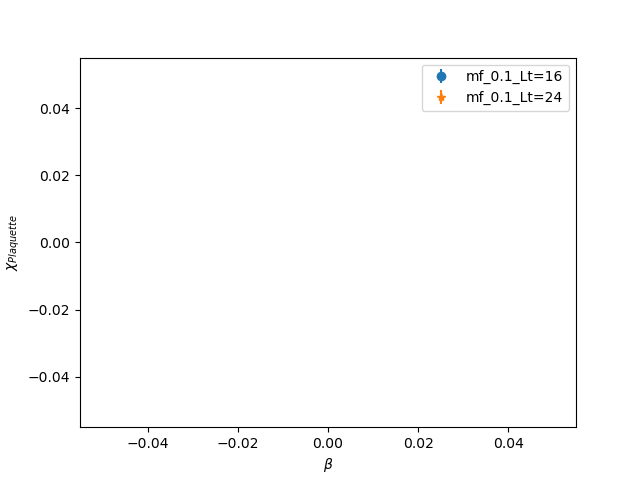

,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept,num_conf


,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept,num_conf


In [42]:
plt.figure()

for (Lt,marker) in zip(Lt_list,itertools.cycle('o*d>^sDHPdpx_')):
    df=df_summary[df_summary.Lt==Lt]
    for mf in mf_list:
        label='mf_%s_Lt=%s'%(mf,Lt)
        df1=df[df.mf==mf].sort_values(by=['beta'])
        display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.sus_poly.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Plaquette}$',rotation='vertical')
plt.savefig('chi_plaq_vs_beta.pdf')

<IPython.core.display.Javascript object>


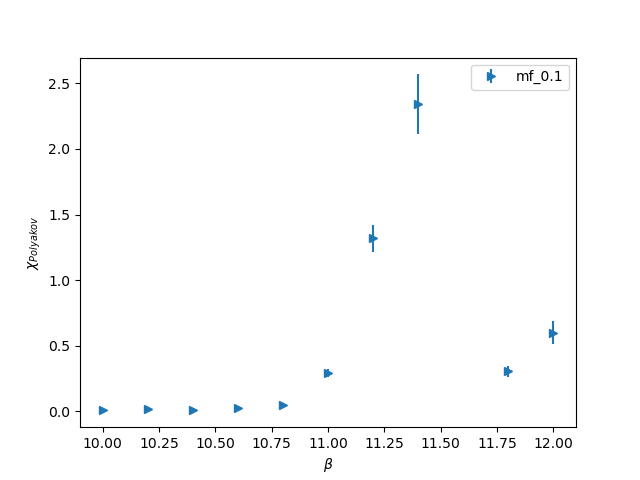

Text(0, 0.5, '$\\chi_{Polyakov}$')

In [18]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.sus_poly.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Polyakov}$',rotation='vertical')
# plt.savefig('chi_poly_vs_beta.pdf')

<IPython.core.display.Javascript object>


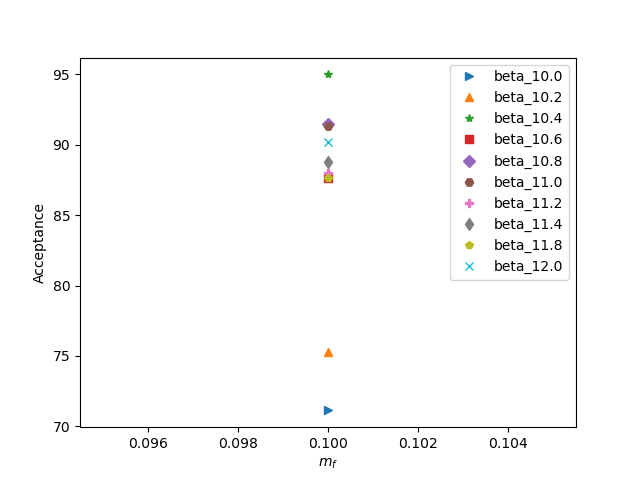

Text(0, 0.5, 'Acceptance')

In [19]:
# Plot acceptance rate 

plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.accept.values
#     print(x,y)
    plt.plot(x,y,linestyle='',label=label,marker=marker)
#     plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Acceptance',rotation='vertical')
# plt.savefig('Acceptance_vs_mf.pdf')

In [27]:
df1

,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept,num_conf
10,12.0,0.1,16,8,16,0.629413(66),0.00105(16),1.44(36)e-07,0.0704(12),0.368(43),1.06(22)e-07,82.20(25),94.949495,59


## Individual plots

In [28]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.2_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.4_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.6_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.8_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16'])

<IPython.core.display.Javascript object>


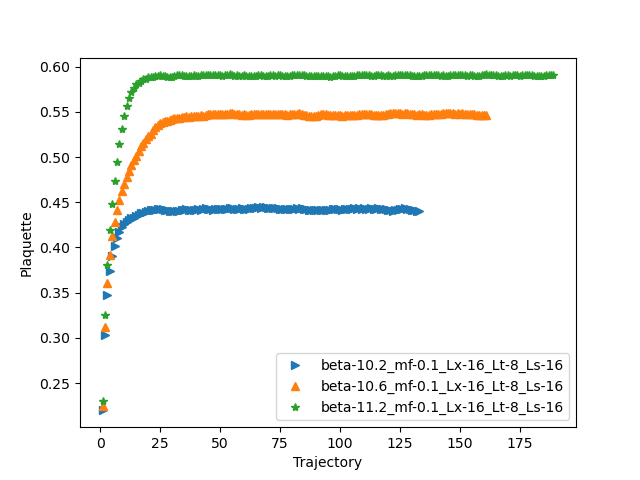

beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16
beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16
beta-11.2_mf-0.1_Lx-16_Lt-8_Ls-16


<IPython.core.display.Javascript object>


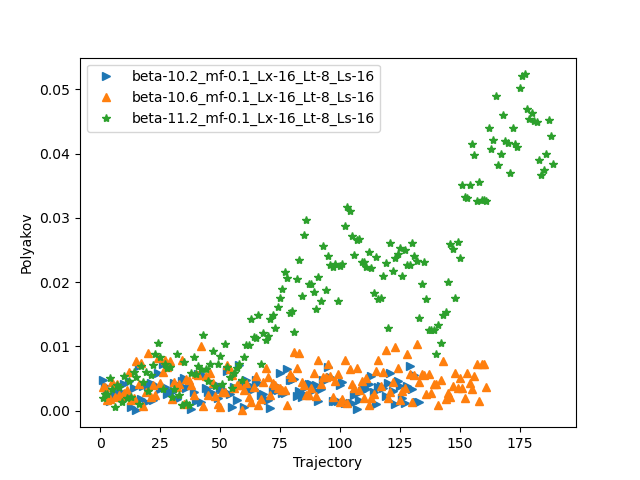

beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16
beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16
beta-11.2_mf-0.1_Lx-16_Lt-8_Ls-16


In [31]:

def f_plot_specific_runs(data_dict,column,keys_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    assert len(keys_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):

        df=data_dict[i]
        label=i
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    
    
# beta_list=[9.0,10.0,10.2,10.4,10.5,10.6,10.8]
beta_list=[10.2,10.6,11.2][:]
mf_list=[0.1]
## Gather dict keys with given beta and mf values
Ls=16
Lt=8
keys_list=['beta-%s_mf-%s_Lx-16_Lt-%s_Ls-%s'%(b,m,Lt,Ls) for m in mf_list for b in beta_list]

f_plot_specific_runs(data_dict,'Plaquette',keys_list)
plt.savefig('Plaq_details.pdf')

# f_plot_specific_runs(dict_list,'Traj_time',keys_list)

f_plot_specific_runs(data_dict,'Polyakov',keys_list)
plt.savefig('Polyakov_details.pdf')


In [ ]:
f_plot_specific_runs(data_dict,'Accept',keys_list)


### Plot Polyakov loop

In [ ]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


In [ ]:
data_dict.keys()

In [ ]:
keys_list

In [ ]:
keys_list=['beta-%s_mf-%s_Lx-16_Lt-8_Ls-16'%(b,m) for m in mf_list for b in beta_list]


fig=plt.figure()

for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):
    df=data_dict[i]
    label=i
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

In [ ]:
# Histogram
beta=10.8
mf=0.1
key='beta-%s_mf-%s_Lx-16_Lt-8_Ls-16'%(beta,mf)

df=data_dict[key]

fig=plt.figure()
x=df.iter.values[:210]
y=np.abs(df.Polyakov.values[:210])

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=50,color='b')

plt.title("Polyakov loop Histogram for beta: %s"%(beta))
plt.savefig('ploop_histogram.pdf')